# Customer Support Quality Analysis

Step-by-step analysis of the generated support chat dataset and LLM-based quality predictions.

**Prerequisites:** Run `generate.py` and `analyze.py` first to produce `data/dataset.json` and `data/analysis.json`.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_absolute_error,
)
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Data

In [2]:
with open('data/dataset.json', 'r') as f:
    dataset = json.load(f)

with open('data/analysis.json', 'r') as f:
    analysis = json.load(f)

analysis_map = {item['id']: item['analysis'] for item in analysis}

rows = []
for d in dataset:
    gt = d['ground_truth']
    pred = analysis_map.get(d['id'], {})
    rows.append({
        'id': d['id'],
        'scenario_type': d['metadata']['scenario_type'],
        'hidden_dissatisfaction': d['metadata']['has_hidden_dissatisfaction'],
        'num_messages': len(d['messages']),
        'gt_intent': gt['intent'],
        'gt_satisfaction': gt['satisfaction'],
        'gt_quality_score': gt['quality_score'],
        'gt_mistakes': gt['agent_mistakes'],
        'pred_intent': pred.get('intent', 'unknown'),
        'pred_satisfaction': pred.get('satisfaction', 'unknown'),
        'pred_quality_score': pred.get('quality_score', 0),
        'pred_mistakes': pred.get('agent_mistakes', []),
    })

df = pd.DataFrame(rows)
print(f'Total dialogs: {len(df)}')
df.head()

Total dialogs: 100


,id,scenario_type,hidden_dissatisfaction,num_messages,gt_intent,gt_satisfaction,gt_quality_score,gt_mistakes,pred_intent,pred_satisfaction,pred_quality_score,pred_mistakes
0,1,successful,False,8,payment_issue,satisfied,5,[],payment_issue,satisfied,5,[]
1,2,successful,False,9,payment_issue,satisfied,4,[],payment_issue,satisfied,5,[]
2,3,successful,False,10,payment_issue,neutral,3,[],payment_issue,satisfied,5,[]
3,4,successful,False,8,payment_issue,satisfied,4,[],payment_issue,satisfied,5,[]
4,5,problematic,False,8,payment_issue,neutral,3,[ignored_question],refund,unsatisfied,3,"[ignored_question, no_resolution]"


## 2. Dataset Overview

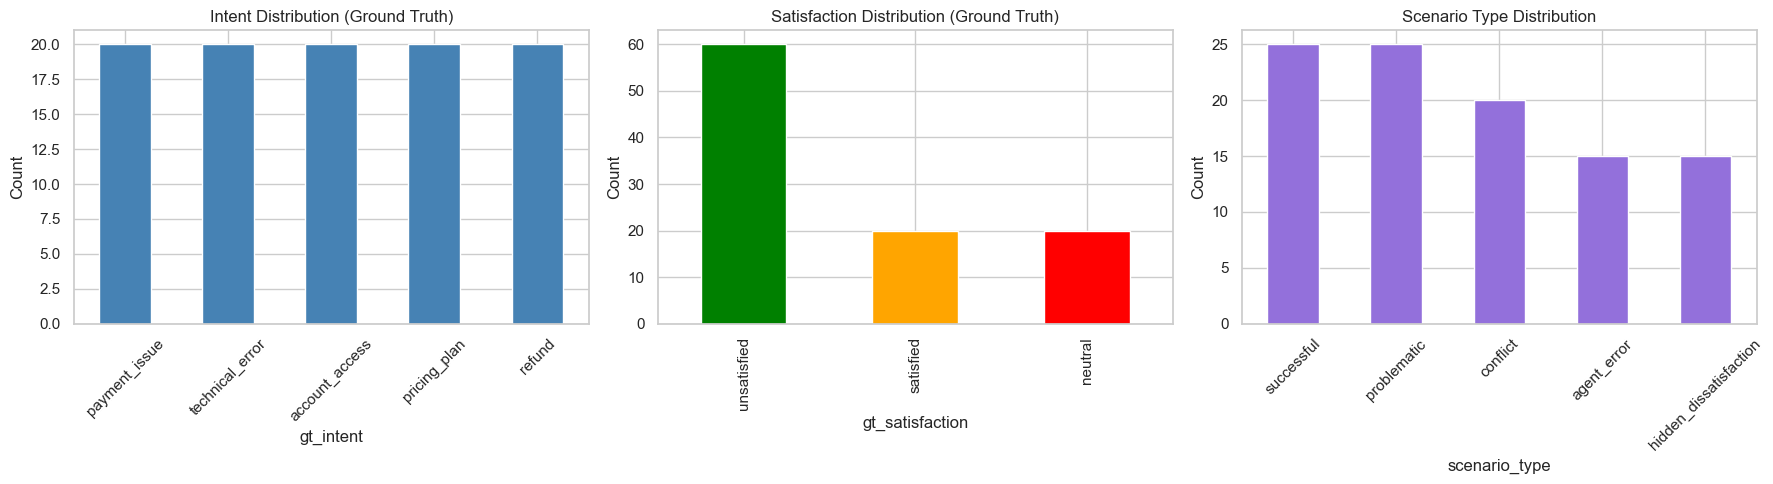


Dialogs with hidden dissatisfaction: 15
Average messages per dialog: 8.4

Quality score distribution (Ground Truth):
gt_quality_score
1    20
2    35
3    25
4    10
5    10
Name: count, dtype: int64


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df['gt_intent'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Intent Distribution (Ground Truth)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

df['gt_satisfaction'].value_counts().plot(kind='bar', ax=axes[1], color=['green', 'orange', 'red'])
axes[1].set_title('Satisfaction Distribution (Ground Truth)')
axes[1].set_ylabel('Count')

df['scenario_type'].value_counts().plot(kind='bar', ax=axes[2], color='mediumpurple')
axes[2].set_title('Scenario Type Distribution')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nDialogs with hidden dissatisfaction: {df['hidden_dissatisfaction'].sum()}")
print(f"Average messages per dialog: {df['num_messages'].mean():.1f}")
print(f"\nQuality score distribution (Ground Truth):")
print(df['gt_quality_score'].value_counts().sort_index())

## 3. Intent Classification: LLM vs Ground Truth

Intent Classification Report:
                 precision    recall  f1-score   support

 account_access       1.00      1.00      1.00        20
  payment_issue       0.53      0.95      0.68        20
   pricing_plan       1.00      0.80      0.89        20
         refund       0.80      1.00      0.89        20
technical_error       1.00      0.15      0.26        20

       accuracy                           0.78       100
      macro avg       0.87      0.78      0.74       100
   weighted avg       0.87      0.78      0.74       100



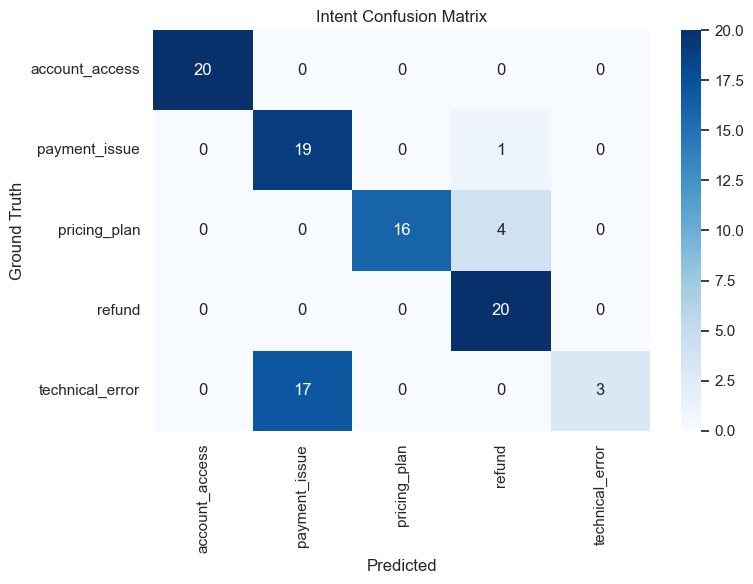


Intent Accuracy: 78.00%


In [4]:
intent_labels = sorted(df['gt_intent'].unique())

print('Intent Classification Report:')
print(classification_report(df['gt_intent'], df['pred_intent'], labels=intent_labels, zero_division=0))

cm = confusion_matrix(df['gt_intent'], df['pred_intent'], labels=intent_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_labels, yticklabels=intent_labels)
plt.title('Intent Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.tight_layout()
plt.show()

intent_acc = accuracy_score(df['gt_intent'], df['pred_intent'])
print(f'\nIntent Accuracy: {intent_acc:.2%}')

## 4. Satisfaction Prediction: LLM vs Ground Truth

Satisfaction Classification Report:
              precision    recall  f1-score   support

   satisfied       0.77      1.00      0.87        20
     neutral       0.00      0.00      0.00        20
 unsatisfied       0.80      0.98      0.88        60

    accuracy                           0.79       100
   macro avg       0.52      0.66      0.58       100
weighted avg       0.63      0.79      0.70       100



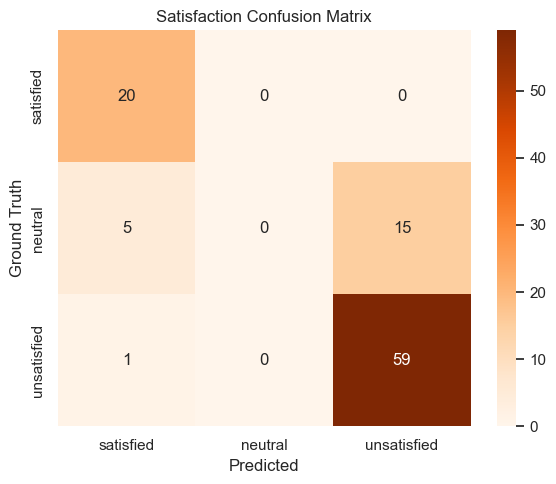


Satisfaction Accuracy: 79.00%


In [5]:
sat_labels = ['satisfied', 'neutral', 'unsatisfied']

print('Satisfaction Classification Report:')
print(classification_report(df['gt_satisfaction'], df['pred_satisfaction'],
                            labels=sat_labels, zero_division=0))

cm_sat = confusion_matrix(df['gt_satisfaction'], df['pred_satisfaction'], labels=sat_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_sat, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sat_labels, yticklabels=sat_labels)
plt.title('Satisfaction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.tight_layout()
plt.show()

sat_acc = accuracy_score(df['gt_satisfaction'], df['pred_satisfaction'])
print(f'\nSatisfaction Accuracy: {sat_acc:.2%}')

## 5. Quality Score Analysis

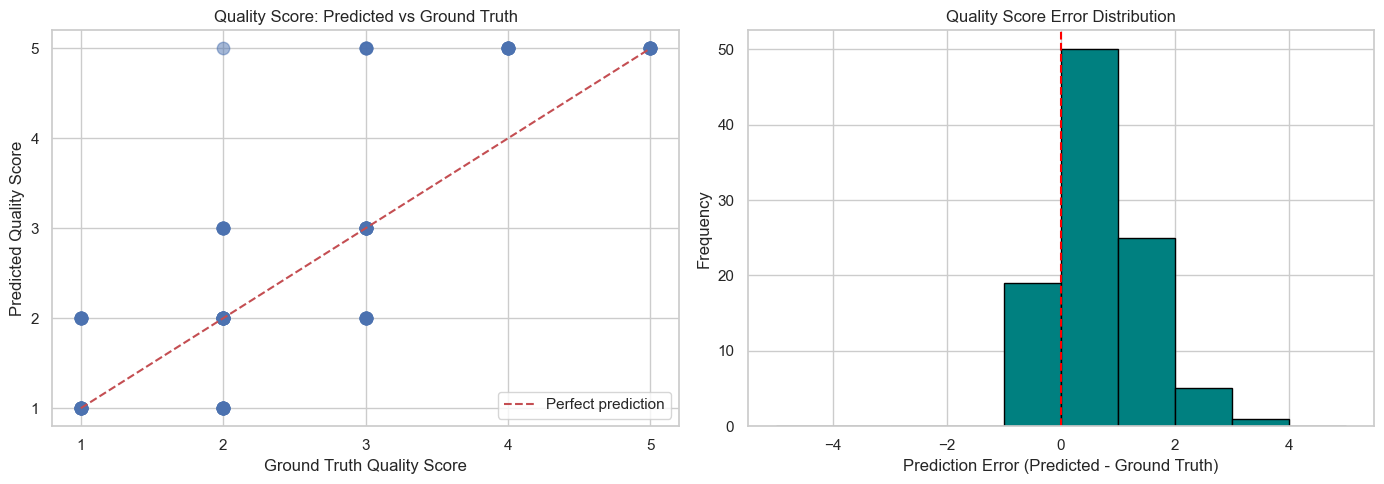

Mean Absolute Error: 0.57
Exact Match: 50.00%
Within +-1: 94.00%
Correlation: 0.829


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['gt_quality_score'], df['pred_quality_score'], alpha=0.5, s=80)
axes[0].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Ground Truth Quality Score')
axes[0].set_ylabel('Predicted Quality Score')
axes[0].set_title('Quality Score: Predicted vs Ground Truth')
axes[0].legend()
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].set_yticks([1, 2, 3, 4, 5])

score_diff = df['pred_quality_score'] - df['gt_quality_score']
score_diff.plot(kind='hist', bins=range(-5, 6), ax=axes[1], color='teal', edgecolor='black')
axes[1].set_xlabel('Prediction Error (Predicted - Ground Truth)')
axes[1].set_title('Quality Score Error Distribution')
axes[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

mae = mean_absolute_error(df['gt_quality_score'], df['pred_quality_score'])
exact_match = (df['gt_quality_score'] == df['pred_quality_score']).mean()
within_one = (abs(df['gt_quality_score'] - df['pred_quality_score']) <= 1).mean()
correlation = df['gt_quality_score'].corr(df['pred_quality_score'])

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Exact Match: {exact_match:.2%}')
print(f'Within +-1: {within_one:.2%}')
print(f'Correlation: {correlation:.3f}')

## 6. Agent Mistakes Detection

Agent Mistakes Detection Metrics:
               mistake  gt_count  pred_count  TP  FP  FN  precision  recall   f1
      ignored_question        25          64  25  39   0       0.39    1.00 0.56
        incorrect_info        25          27  23   4   2       0.85    0.92 0.88
             rude_tone        15          18  15   3   0       0.83    1.00 0.91
         no_resolution        35          73  35  38   0       0.48    1.00 0.65
unnecessary_escalation        15           6   6   0   9       1.00    0.40 0.57


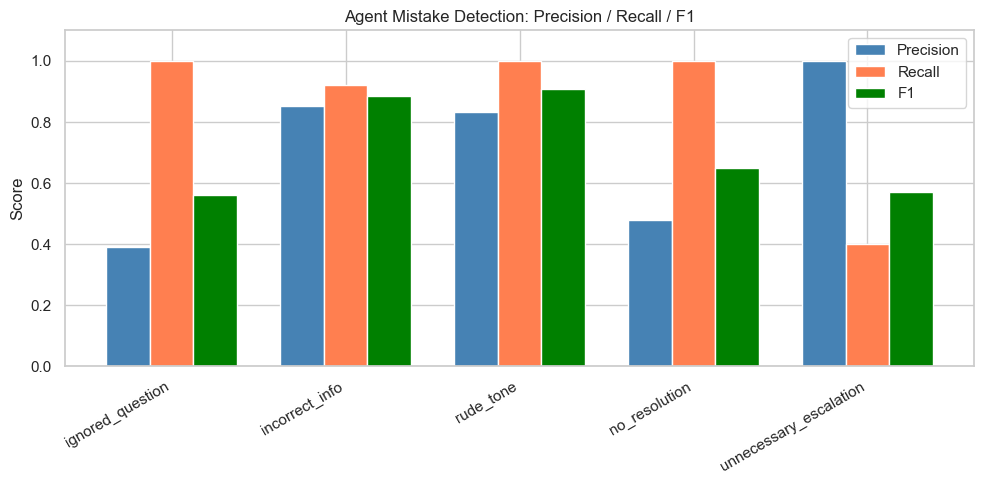

In [7]:
all_mistakes = ['ignored_question', 'incorrect_info', 'rude_tone', 'no_resolution', 'unnecessary_escalation']

mistake_metrics = []
for mistake in all_mistakes:
    gt_has = df['gt_mistakes'].apply(lambda x: mistake in x)
    pred_has = df['pred_mistakes'].apply(lambda x: mistake in x)

    tp = (gt_has & pred_has).sum()
    fp = (~gt_has & pred_has).sum()
    fn = (gt_has & ~pred_has).sum()
    tn = (~gt_has & ~pred_has).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    mistake_metrics.append({
        'mistake': mistake,
        'gt_count': gt_has.sum(),
        'pred_count': pred_has.sum(),
        'TP': tp, 'FP': fp, 'FN': fn,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    })

mistakes_df = pd.DataFrame(mistake_metrics)
print('Agent Mistakes Detection Metrics:')
print(mistakes_df.to_string(index=False, float_format='%.2f'))

fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(all_mistakes))
width = 0.25
ax.bar([i - width for i in x], mistakes_df['precision'], width, label='Precision', color='steelblue')
ax.bar(x, mistakes_df['recall'], width, label='Recall', color='coral')
ax.bar([i + width for i in x], mistakes_df['f1'], width, label='F1', color='green')
ax.set_xticks(x)
ax.set_xticklabels(all_mistakes, rotation=30, ha='right')
ax.set_ylabel('Score')
ax.set_title('Agent Mistake Detection: Precision / Recall / F1')
ax.legend()
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

## 7. Anomaly Detection: Hidden Dissatisfaction

Total dialogs with hidden dissatisfaction: 15

LLM correctly detected hidden dissatisfaction: 14/15 (93%)
LLM missed (predicted satisfied/neutral): 1/15

Missed cases (LLM thought customer was satisfied/neutral):
  Dialog 17: predicted=satisfied, intent=payment_issue, scenario=hidden_dissatisfaction


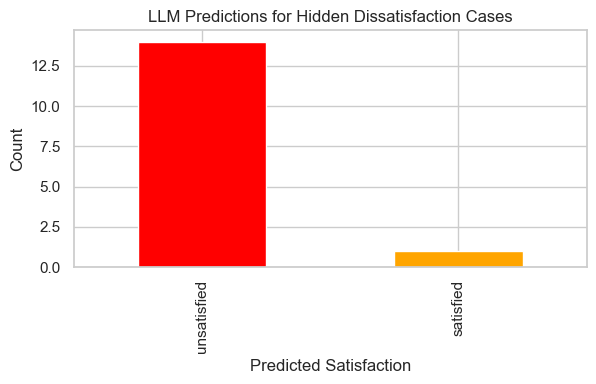

In [8]:
hidden = df[df['hidden_dissatisfaction'] == True].copy()
print(f'Total dialogs with hidden dissatisfaction: {len(hidden)}')
print()

hidden_detected = hidden[hidden['pred_satisfaction'] == 'unsatisfied']
hidden_missed = hidden[hidden['pred_satisfaction'] != 'unsatisfied']

detection_rate = len(hidden_detected) / len(hidden) if len(hidden) > 0 else 0
print(f'LLM correctly detected hidden dissatisfaction: {len(hidden_detected)}/{len(hidden)} ({detection_rate:.0%})')
print(f'LLM missed (predicted satisfied/neutral): {len(hidden_missed)}/{len(hidden)}')

if len(hidden_missed) > 0:
    print('\nMissed cases (LLM thought customer was satisfied/neutral):')
    for _, row in hidden_missed.iterrows():
        print(f'  Dialog {row["id"]}: predicted={row["pred_satisfaction"]}, '
              f'intent={row["gt_intent"]}, scenario={row["scenario_type"]}')

fig, ax = plt.subplots(figsize=(6, 4))
hidden['pred_satisfaction'].value_counts().plot(kind='bar', ax=ax, color=['red', 'orange', 'green'])
ax.set_title('LLM Predictions for Hidden Dissatisfaction Cases')
ax.set_ylabel('Count')
ax.set_xlabel('Predicted Satisfaction')
plt.tight_layout()
plt.show()

## 8. Disagreement Analysis

Total disagreements (intent OR satisfaction mismatch OR quality diff >= 2): 39
  Intent mismatches: 22
  Satisfaction mismatches: 21
  Quality score diff >= 2: 6

Sample disagreements:
 id          scenario_type       gt_intent     pred_intent gt_satisfaction pred_satisfaction  gt_quality_score  pred_quality_score
  3             successful   payment_issue   payment_issue         neutral         satisfied                 3                   5
  5            problematic   payment_issue          refund         neutral       unsatisfied                 3                   3
  7            problematic   payment_issue   payment_issue         neutral       unsatisfied                 3                   2
 17 hidden_dissatisfaction   payment_issue   payment_issue     unsatisfied         satisfied                 2                   5
 19            problematic   payment_issue   payment_issue         neutral       unsatisfied                 3                   3
 21             successful te

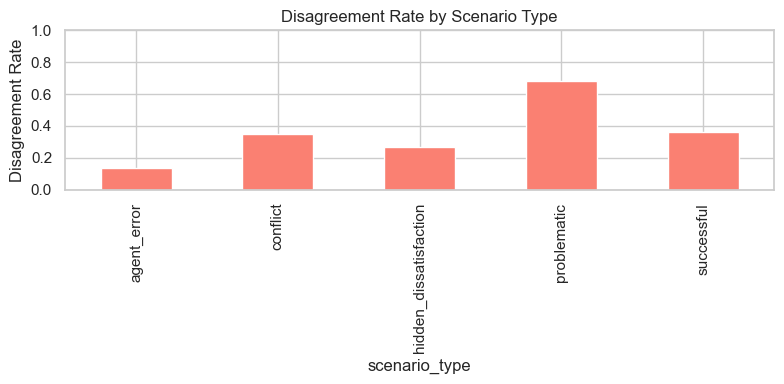

In [9]:
df['intent_match'] = df['gt_intent'] == df['pred_intent']
df['satisfaction_match'] = df['gt_satisfaction'] == df['pred_satisfaction']
df['quality_diff'] = abs(df['gt_quality_score'] - df['pred_quality_score'])

disagreements = df[
    (~df['intent_match']) | (~df['satisfaction_match']) | (df['quality_diff'] >= 2)
].copy()

print(f'Total disagreements (intent OR satisfaction mismatch OR quality diff >= 2): {len(disagreements)}')
print(f'  Intent mismatches: {(~df["intent_match"]).sum()}')
print(f'  Satisfaction mismatches: {(~df["satisfaction_match"]).sum()}')
print(f'  Quality score diff >= 2: {(df["quality_diff"] >= 2).sum()}')

if len(disagreements) > 0:
    print('\nSample disagreements:')
    cols = ['id', 'scenario_type', 'gt_intent', 'pred_intent',
            'gt_satisfaction', 'pred_satisfaction', 'gt_quality_score', 'pred_quality_score']
    print(disagreements[cols].head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
disagree_by_type = disagreements['scenario_type'].value_counts()
all_by_type = df['scenario_type'].value_counts()
disagree_rate = (disagree_by_type / all_by_type).fillna(0)
disagree_rate.plot(kind='bar', ax=ax, color='salmon')
ax.set_title('Disagreement Rate by Scenario Type')
ax.set_ylabel('Disagreement Rate')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 9. Summary

In [10]:
print('=' * 60)
print('ANALYSIS SUMMARY')
print('=' * 60)
print(f'Total dialogs analyzed: {len(df)}')
print(f'\nIntent classification accuracy: {accuracy_score(df["gt_intent"], df["pred_intent"]):.2%}')
print(f'Satisfaction classification accuracy: {accuracy_score(df["gt_satisfaction"], df["pred_satisfaction"]):.2%}')
print(f'Quality score MAE: {mean_absolute_error(df["gt_quality_score"], df["pred_quality_score"]):.2f}')
print(f'Quality score correlation: {df["gt_quality_score"].corr(df["pred_quality_score"]):.3f}')
print(f'\nHidden dissatisfaction detection rate: {detection_rate:.0%}')
print(f'Total disagreements: {len(disagreements)} / {len(df)}')
print(f'\nAgent mistake detection (avg F1): {mistakes_df["f1"].mean():.2f}')
print('=' * 60)

ANALYSIS SUMMARY
Total dialogs analyzed: 100

Intent classification accuracy: 78.00%
Satisfaction classification accuracy: 79.00%
Quality score MAE: 0.57
Quality score correlation: 0.829

Hidden dissatisfaction detection rate: 93%
Total disagreements: 39 / 100

Agent mistake detection (avg F1): 0.72
